# Survival Analysis Exploration

## Python Survival Packages
 - [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html): This seems like the best library with ML survival methods.  It is under active development.  Stylistically and technically consistent with sklearn.  It does seem somewhat immature with some key things not implemented yet like some feature importances, some features associated with ensemble tree methods like warm start gradient boosting, etc.
 - [pysurvival](https://square.github.io/pysurvival/): This library has a decent amount of base survival functionality but doesn't seem to be active.  No commits have been made since 2019.
 - [lifelines](https://lifelines.readthedocs.io/en/latest/index.html): This seems to be a really robust package under active development that has solid survival analysis basics.  It's missing some ML methods and ensemble methods but is likely a better choice for basic models like Cox and paremetric regressions.  Seems more 'statistics-flavored' rather than 'ML-flavored' 

Adapted this code from the Scikit-Survival documentation here:
 * https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html

Used a different larger test dataset from the package in order to have some different results.

`conda env export > environment.yml`

## Imports and Data Preprocessing

In [24]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sksurv.datasets import load_flchain
from sksurv.preprocessing import OneHotEncoder
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter

In [25]:
X, y = load_flchain()
print(X.columns)
X.info()

Index(['age', 'chapter', 'creatinine', 'flc.grp', 'kappa', 'lambda', 'mgus',
       'sample.yr', 'sex'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7874 entries, 0 to 7873
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         7874 non-null   float64 
 1   chapter     2169 non-null   category
 2   creatinine  6524 non-null   float64 
 3   flc.grp     7874 non-null   category
 4   kappa       7874 non-null   float64 
 5   lambda      7874 non-null   float64 
 6   mgus        7874 non-null   category
 7   sample.yr   7874 non-null   category
 8   sex         7874 non-null   category
dtypes: category(5), float64(4)
memory usage: 286.3 KB


In [44]:
df = X.merge(pd.DataFrame(y), left_index=True, right_index=True)

<AxesSubplot:xlabel='sample.yr', ylabel='Count'>

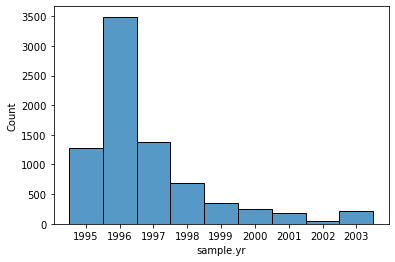

In [4]:
sns.histplot(X["sample.yr"])

<AxesSubplot:xlabel='creatinine', ylabel='Count'>

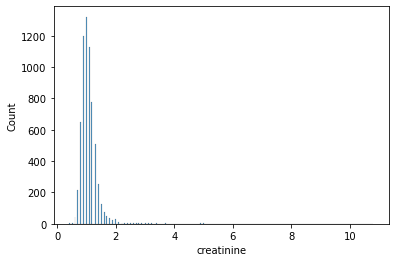

In [5]:
sns.histplot(X["creatinine"])

<AxesSubplot:xlabel='age', ylabel='Count'>

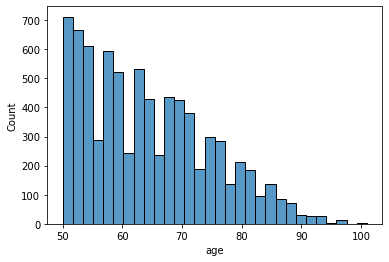

In [6]:
sns.histplot(X["age"])

<AxesSubplot:xlabel='lambda', ylabel='Count'>

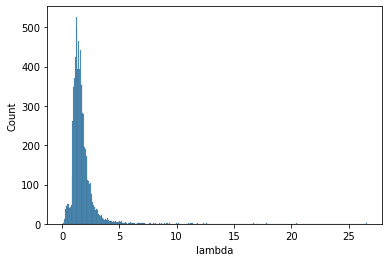

In [7]:
sns.histplot(X["lambda"])

Some observations on the data:
 - age, kappa, and lambda are all numeric with no missing values so no pre-processing needed right now.  Maybe bucketing ages later?
 - Need to deal with missing values in creatinine and chapter.  Creatinine is numeric so likely use median?  Chapter is categorical so I can treat the missing as a category when I one-hot-encode.  May not be appropriate, need to research data.
 - Creatinine and lambda seem a bit right-skewed, consider ln or box cox to remove skew
 - Need to one-hot encode chapter, flc.grp, mgus, and sex

In [8]:
X["chapter"] = X["chapter"].cat.add_categories(["None"]).fillna("None")
X["creatinine"] = X["creatinine"].fillna(X["creatinine"].median())
X["sample.yr"] = X["sample.yr"].astype(int)

In [9]:
# Removing right skew with log transforms.  CPH performance improved with these changes
X["lambda"] = np.log(X["lambda"])
X["creatinine"] = np.log(X["creatinine"])

In [10]:
# One hot encode the appropriate categorical variables
X_ohes = OneHotEncoder().fit_transform(X[['chapter', 'flc.grp', 'mgus', 'sex']])
X_ohes.columns

Index(['chapter=Circulatory', 'chapter=Congenital', 'chapter=Digestive',
       'chapter=Endocrine', 'chapter=External Causes', 'chapter=Genitourinary',
       'chapter=Ill Defined', 'chapter=Infectious',
       'chapter=Injury and Poisoning', 'chapter=Mental',
       'chapter=Musculoskeletal', 'chapter=Neoplasms', 'chapter=Nervous',
       'chapter=Respiratory', 'chapter=Skin', 'chapter=None', 'flc.grp=2',
       'flc.grp=3', 'flc.grp=4', 'flc.grp=5', 'flc.grp=6', 'flc.grp=7',
       'flc.grp=8', 'flc.grp=9', 'flc.grp=10', 'mgus=yes', 'sex=M'],
      dtype='object')

In [11]:
X_processed = pd.concat([X_ohes, X[["age", "kappa", "lambda", "sample.yr", "creatinine"]]], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.3, random_state = 56)

## Kaplan-Meier Estimator

Text(0.5, 0, 'time $t$')

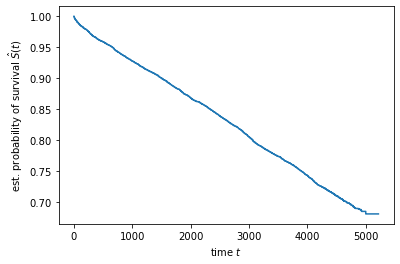

In [13]:
time, survival_prob = kaplan_meier_estimator(y["death"], y["futime"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Fit KM for two different categories in the data.  This code is quite a bit more manual and verbose than how it's implemented in R.  This would be a pain to do for another factor on top of this one.  

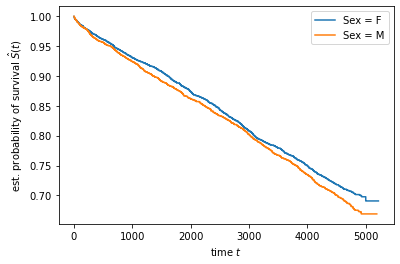

In [22]:
for sex in X.sex.unique():
    filt = X["sex"] == sex
    time, survival_prob = kaplan_meier_estimator(y["death"][filt], y["futime"][filt])
    
    plt.step(time, survival_prob, where="post",
             label="Sex = %s" % sex)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Prep the data to fix a CPH model.  First need to determine what to do with NA values.  The continuous variable creatinine is missing 1350/7874 values for creatinine.  The discrete variable chapter is missing 5705/7874 values.  Chapter appears to be the ICD cause of death, so it is only populated for records where there was a death.  We can't use this variable for modeling since we only know the cause of death after death happens.

In [15]:
X.isna().sum()

age           0
chapter       0
creatinine    0
flc.grp       0
kappa         0
lambda        0
mgus          0
sample.yr     0
sex           0
dtype: int64

For creatinine, we could either exclude the records with missing creatinine or look to impute values of creatinine.  First, I want to understand whether or not there is a difference in survival outcomes for records with missing creatinine vs non-missing creatinine. 

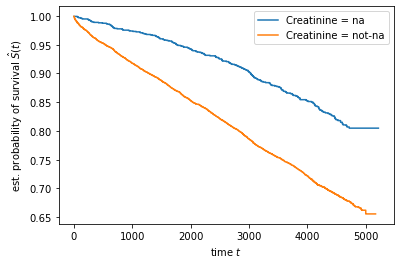

In [23]:
for val in ["na", "not-na"]:
    if val == "na":
        filt = X["creatinine"].isna()
    else: 
        filt = ~X["creatinine"].isna()
    time, survival_prob = kaplan_meier_estimator(y["death"][filt], y["futime"][filt])
    
    plt.step(time, survival_prob, where="post",
             label="Creatinine = %s" % val)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

From the KM analysis, it appears that for missing values of creatinine, survival is significanly higher. This means there is likely a structural reason that creatinine is missing from these records.  For the initial model, I'm going to exclude this variable

## Cox Proportional Hazard Regression

In [63]:
cph = CoxPHSurvivalAnalysis(alpha = 0.0001)
cph.fit(X_train[["age", "kappa"]], y_train)

CoxPHSurvivalAnalysis(alpha=0.0001)

In [65]:
cph.score(X_test[["age", "kappa"]], y_test)
# 0.9357476907520315

0.7891798801885318

## CPH with Splines
https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Custom%20Regression%20Models.html?highlight=spline#Spline-models

In [45]:
train, test = train_test_split(df, test_size = 0.3, random_state = 56)

In [99]:
cph = CoxPHFitter().fit(train, "futime", "death", formula="bs(age, df=4) + kappa")
# "bs(age, df=4) + kappa + lambda + sample.yr"

In [112]:
cph = CoxPHFitter().fit(train, "futime", "death", formula="age + kappa")


In [113]:
cph.score(test, scoring_method = 'concordance_index')

0.7891798801885318

<AxesSubplot:>

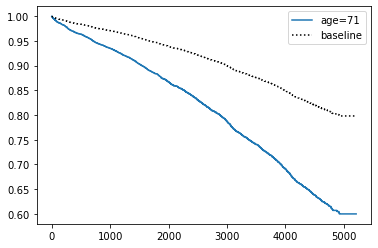

In [122]:
cph.plot_partial_effects_on_outcome("age", values=[71])

In [ ]:
cph.predict_partial_hazard()

## Random Survival Forests

In [64]:
from sksurv.ensemble import RandomSurvivalForest

In [65]:
estimator = RandomSurvivalForest(n_estimators = 1000,
                                 min_samples_leaf = 2,
                                 max_features = "sqrt",
                                 max_samples = 0.1,
                                 bootstrap = True,
                                 n_jobs = 7,
                                 verbose = 1,
                                 random_state = 56)

In [66]:
estimator.fit(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    1.5s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    6.0s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    7.8s finished


RandomSurvivalForest(max_features='sqrt', max_samples=0.1, min_samples_leaf=2,
                     n_estimators=1000, n_jobs=7, random_state=56, verbose=1)

In [67]:
estimator.verbose = 0
print("Train Score: ", estimator.score(X_train, y_train))
print("Test Score: ", estimator.score(X_test, y_test))
#Train Score:  0.9431387630037822
#Test Score:  0.9341502599463144


Train Score:  0.9431314726537451
Test Score:  0.9341228183968148


## Gradient Boosted Tree Models

In [68]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [72]:
estimator = GradientBoostingSurvivalAnalysis(n_estimators = 500,
                                             learning_rate = 0.1,
                                             verbose = 1,
                                             random_state = 56,
                                             max_features = "sqrt",
                                             subsample = 0.3)

In [73]:
estimator.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        3307.4102          22.0019            2.83m
         2        3402.8593          35.7648            2.91m
         3        3255.4294          32.4242            2.90m
         4        3233.1090          24.4516            2.90m
         5        3237.7029          29.0091            2.90m
         6        3157.2566          38.1562            2.88m
         7        3100.2434          28.2093            2.88m
         8        2874.1364          17.0898            2.89m
         9        3165.0194          40.9808            2.88m
        10        3035.9300          51.4690            2.89m
        20        2788.4575          69.8953            2.85m
        30        2717.1215          47.3913            2.82m
        40        2680.0664          10.9275            2.78m
        50        2583.8611           4.8474            2.75m
        60        2650.4100          17.0003            2.70m
       

GradientBoostingSurvivalAnalysis(max_features='sqrt', n_estimators=500,
                                 random_state=56, subsample=0.3, verbose=1)

In [74]:
estimator.verbose = 0
print("Train Score: ", estimator.score(X_train, y_train))
print("Test Score: ", estimator.score(X_test, y_test))


Train Score:  0.9474260963547338
Test Score:  0.9362749011272656
